# Feature Selecection

In [161]:
import json


# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# General
import numpy as np


# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split


# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


# BINARY CLASSIFICATION METRICS
from sklearn.metrics import RocCurveDisplay


# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

# Import Processed Data

In [162]:
# FETCH DATA
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date" , inplace=True)

# Specify Prediction Target

In [163]:
# Specify Target     (if yesterdays range was greater than the average range)
df.loc[df["Range"].shift(-1) > df["AVG_Range"] , "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["AVG_Range"] , "TARGET"] = 0

# Check for NAN
nan_location = np.where(np.isnan(df))

# Fill NaNs
df["TARGET"].fillna(0,inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Return,...,DOW,Rolling_rets,AVG_Range,Returns_T1,Range_T1,Rolling_rets_T1,Returns_T2,Range_T2,Rolling_rets_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-09,-0.001330,-0.004010,-0.015793,27583.677734,0.516718,-0.012580,0.025159,3.185758,55.925229,0.910373,...,0,0.066139,0.022740,-0.001207,0.013032,0.078333,0.000796,0.005657,0.066791,0.0
2023-10-10,-0.012360,-0.009776,-0.000033,27391.019531,-0.169418,-0.006985,0.015171,3.156683,53.114576,0.949743,...,1,0.061605,0.022806,-0.012580,0.025159,0.066139,-0.001207,0.013032,0.078333,1.0
2023-10-11,-0.007145,-0.008722,-0.027125,26873.320312,0.368456,-0.018900,0.034374,3.078116,46.370587,0.873029,...,2,0.068624,0.022677,-0.006985,0.015171,0.061605,-0.012580,0.025159,0.066139,0.0
2023-10-12,-0.018939,-0.020116,-0.000105,26756.798828,-0.311779,-0.004336,0.013673,3.059839,44.986082,0.970143,...,3,0.037634,0.021383,-0.018900,0.034374,0.068624,-0.006985,0.015171,0.061605,0.0
2023-10-13,-0.004481,0.006361,0.004820,26862.375000,0.614549,0.003946,0.015228,3.076439,46.543471,1.034619,...,4,0.026290,0.021122,-0.004336,0.013673,0.037634,-0.018900,0.034374,0.068624,0.0


# TRAIN TEST SPLIT

In [164]:
# FETCH RECOMMENDED FEATURES FROM FEATURE SELECTION
with open('./data/feature_selection_output.json', 'r') as f:
    recommended_labels = json.load(f)
recommended_labels.append("TARGET")
recommended_labels

['Low', 'Range', 'RSI', 'RSI_Return', 'DOW', 'AVG_Range', 'TARGET']

In [165]:
# REMOVE UNWANTED COLUMNS (dont put information about the future in your data other than the target)
df_tts = df.copy()
df_tts = df_tts[recommended_labels]

In [166]:
# EVERYTHING EXCEPT TARGET (x)
X = df_tts.iloc[: , : -1]

# TARGET (y)
y = df_tts.iloc[: , -1]
df_tts 

,Low,Range,RSI,RSI_Return,DOW,AVG_Range,TARGET
Date,,,,,,,
2020-02-02,-0.010245,0.027227,68.352715,0.975766,6,0.033705,0.0
2020-02-03,0.003342,0.031544,66.532818,0.973375,0,0.034219,0.0
2020-02-04,-0.014686,0.023972,62.561591,0.940312,1,0.034370,1.0
2020-02-05,0.005585,0.058666,69.976461,1.118521,2,0.034649,0.0
2020-02-06,0.041044,0.029854,71.606200,1.023290,3,0.033885,0.0
...,...,...,...,...,...,...,...
2023-10-09,-0.015793,0.025159,55.925229,0.910373,0,0.022740,0.0
2023-10-10,-0.000033,0.015171,53.114576,0.949743,1,0.022806,1.0
2023-10-11,-0.027125,0.034374,46.370587,0.873029,2,0.022677,0.0


In [167]:
# TRAIN TEST SPLIT (time series)


# 70% OF THE HISTORICAL DATA GOES TO TRAINING THE MODEL
train_amount_percent = 0.7
train_size = int(len(X) * train_amount_percent)
X_train = X.head(train_size)
y_train = y.head(train_size)


# THE REST GOES TO TESTING THE MODEL FOR ACCURACY
test_size = len(X) - train_size
X_test = X.tail(test_size)
y_test = y.tail(test_size)

In [168]:
size_check = len(y_test) + len(y_train) == len(X)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print()
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print()
print(f"Testing data size check: {size_check}")

Shape of X_train: (944, 6)
Shape of y_train: (944,)

Shape of X_test: (406, 6)
Shape of y_test: (406,)

Testing data size check: True


# BUILD MODEL

In [169]:
# Select type of model to optimize for
is_binary = True
is_optimize_for_precision = True


In [170]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error","logloss",eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror","mlogloss",eval_metric]

In [171]:
# Refine Eval Metric
if is_binary and is_optimize_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimize_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [172]:
# hyperparameters generated in feature selection


with open('./data/hyperparametertuning.json', 'r') as f:
    data = json.load(f)
    ne = data['ne']
    lr = data['lr']
    md = data['md']
    gm = data['gm']




# CUSTOM HYPER PARAM TUNE
# ne = 150
# lr = 0.01
# md = 4
# gm = 6


In [173]:
# Build First Classifier Model
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    # eval_metric=eval_metric,
    subsample = 0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False,

    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
)

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [174]:
# Fit the model
eval_set = [(X_train,y_train) , (X_test,y_test)]

classifier.fit(
    X_train,
    y_train,
    eval_metric=eval_metric_list,
    eval_set=eval_set,
    verbose=False
)


d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

# MAKE PREDICTIONS
- binary if the next day will be up (1) or down (0) the next day 

In [175]:
# training data
next_day_target_predictions = classifier.predict(X_train)
train_yhat_probability = classifier.predict_proba(X_train)


# OUTPUT
prediction_probabilities = zip(next_day_target_predictions , train_yhat_probability)
print("Predcition \t|\t Binary Confidence (zero or one)")
print("___________________________________________________\n")
for prediction , probability_confidence in list(prediction_probabilities)[:10]:
    print(prediction, "\t\t|\t",  probability_confidence)

Predcition 	|	 Binary Confidence (zero or one)
___________________________________________________

0 		|	 [0.56688637 0.43311363]
0 		|	 [0.5833398  0.41666016]
0 		|	 [0.6138208 0.3861792]
0 		|	 [0.5833398  0.41666016]
0 		|	 [0.5833398  0.41666016]
0 		|	 [0.5999158 0.4000842]
0 		|	 [0.5999158 0.4000842]
1 		|	 [0.49882233 0.50117767]
0 		|	 [0.57195497 0.42804506]
0 		|	 [0.5833398  0.41666016]


# TEST MODEL ACCURACY

In [176]:
# TEST Y HAT
test_next_day_target_predictions = classifier.predict(X_test)
test_yhat_probability = classifier.predict_proba(X_test)


# OUTPUT
prediction_probabilities = zip(test_next_day_target_predictions , test_yhat_probability)
print("Predcition \t|\t Binary Confidence (zero or one)")
print("___________________________________________________\n")
for prediction , probability_confidence in list(prediction_probabilities)[:10]:
    print(prediction, "\t\t|\t",  probability_confidence)

Predcition 	|	 Binary Confidence (zero or one)
___________________________________________________

0 		|	 [0.6332762  0.36672375]
0 		|	 [0.6011699  0.39883012]
0 		|	 [0.6172005  0.38279954]
0 		|	 [0.5111739 0.4888261]
0 		|	 [0.6172005  0.38279954]
0 		|	 [0.6172005  0.38279954]
0 		|	 [0.62051654 0.37948346]
0 		|	 [0.6332762  0.36672375]
0 		|	 [0.6011699  0.39883012]
0 		|	 [0.6172005  0.38279954]


# K FOLD CROSS VALIDATION

In [177]:
# KFOLD CROSS VALIDATION
cv = RepeatedStratifiedKFold(n_splits=5 , n_repeats=1, random_state=1)

In [178]:
# Training results 
train_results = cross_val_score(classifier, X_train, y_train , cv=cv , n_jobs=1 )

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


# EVALUTION METRICS - Loss & Overfitting

In [179]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0,epochs)

Text(0.5, 1.0, 'XGB LogLoss')

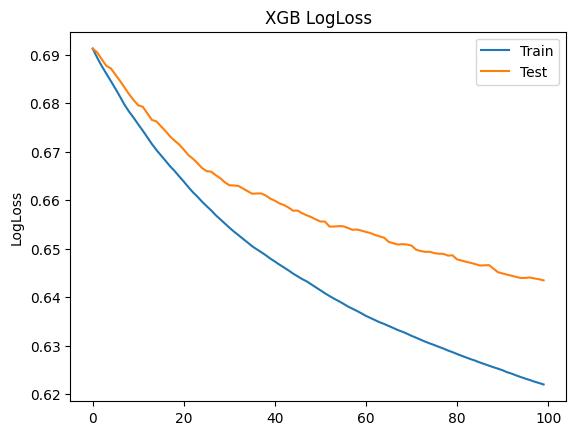

In [180]:
# Plot log loss
fig,axis = plt.subplots()
axis.plot(x_axis , results["validation_0"]["logloss"], label="Train")
axis.plot(x_axis , results["validation_1"]["logloss"], label="Test")
axis.legend()
plt.ylabel("LogLoss")
plt.title("XGB LogLoss")

Text(0.5, 1.0, 'XGB Error')

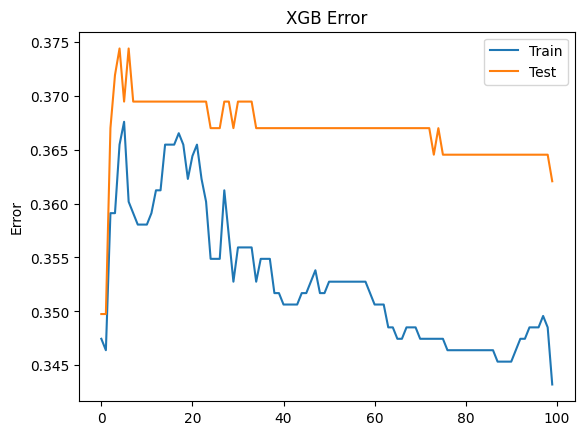

In [181]:
# Plot error
fig,axis = plt.subplots()
axis.plot(x_axis , results["validation_0"]["error"], label="Train")
axis.plot(x_axis , results["validation_1"]["error"], label="Test")
axis.legend()
plt.ylabel("Error")
plt.title("XGB Error")

# Evaluate ROC Curve

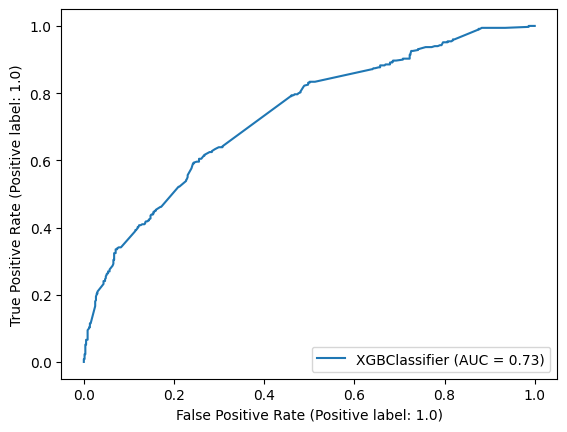

In [182]:
# Plot Training ROC Curve
RocCurveDisplay.from_estimator(classifier, X_train, y_train)

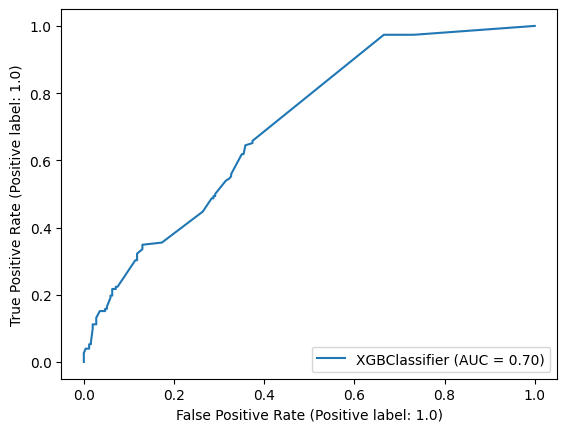

In [183]:
# Plot Test ROC Curve
RocCurveDisplay.from_estimator(classifier, X_test, y_test)

# Performance Evaluation Comparison

In [184]:
# Set K-Fold cross validation 
cv = RepeatedStratifiedKFold(n_splits=5 , n_repeats=1, random_state=1)

In [185]:
# training results
train_results  =  cross_val_score(classifier , X_train, y_train, scoring=scoring, cv=cv , n_jobs=-1)
test_results  =  cross_val_score(classifier , X_test, y_test, scoring=scoring, cv=cv , n_jobs=-1)

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [186]:
# Comparison of results 
print("TRAIN:", )
print("\tAverage Accuracy k-Fold",round(train_results.mean(),2) )
print("\tStandard Deviation k-Fold",round(train_results.std(),2) )
print("\tPrecision Score 0:", round(precision_score(y_train, next_day_target_predictions, average=None)[0] , 3) )
print("\tPrecision Score 1:", round(precision_score(y_train, next_day_target_predictions, average=None)[1] , 3) )
print("\n-----------------------------------------------------------------------------\n")
print("TEST:", )
print("\tAverage Accuracy k-Fold",round(test_results.mean(),2) )
print("\tStandard Deviation k-Fold",round(test_results.std(),2) )
print("\tPrecision Score 0:", round(precision_score(y_test, test_next_day_target_predictions, average=None)[0] , 3) )
print("\tPrecision Score 1:", round(precision_score(y_test, test_next_day_target_predictions, average=None)[1] , 3) )
print("\n-----------------------------------------------------------------------------\n")

TRAIN:
	Average Accuracy k-Fold 0.65
	Standard Deviation k-Fold 0.12
	Precision Score 0: 0.649
	Precision Score 1: 0.857

-----------------------------------------------------------------------------

TEST:
	Average Accuracy k-Fold 0.71
	Standard Deviation k-Fold 0.13
	Precision Score 0: 0.634
	Precision Score 1: 0.857

-----------------------------------------------------------------------------



# Evalutation Metrics - Summary Report
- looking at  `training` data prediction accuracy

In [187]:
print (classification_report(y_train, next_day_target_predictions))

              precision    recall  f1-score   support

         0.0       0.65      0.99      0.78       595
         1.0       0.86      0.09      0.16       349

    accuracy                           0.66       944
   macro avg       0.75      0.54      0.47       944
weighted avg       0.73      0.66      0.55       944



- looking at `testing` data prediction accuracy

In [188]:
print (classification_report(y_test, test_next_day_target_predictions))

              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77       254
         1.0       0.86      0.04      0.08       152

    accuracy                           0.64       406
   macro avg       0.75      0.52      0.43       406
weighted avg       0.72      0.64      0.51       406



# Performance Evaluation - Confusion Matrix

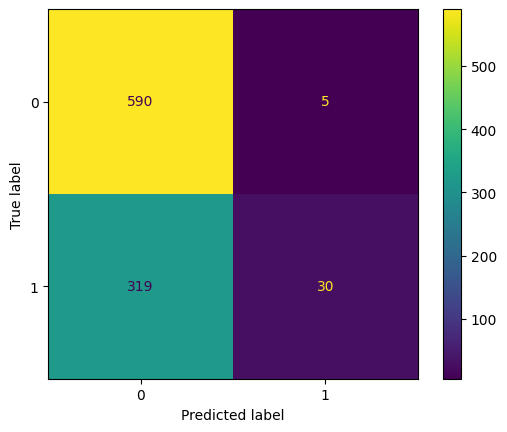

In [189]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, next_day_target_predictions)
ConfusionMatrixDisplay(cm_train).plot()

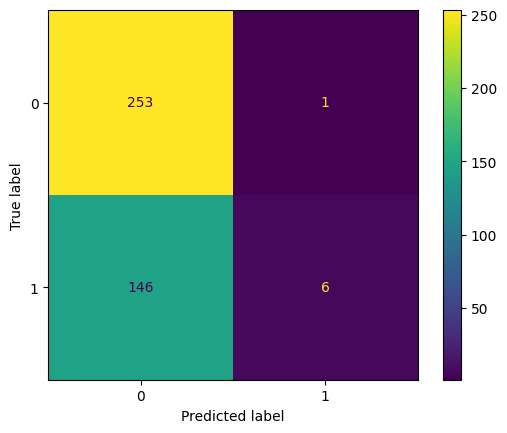

In [190]:
# Testing Confusion Matrix
cm_test = confusion_matrix(y_test, test_next_day_target_predictions)
ConfusionMatrixDisplay(cm_test).plot()

# Feature Importance
- most influential features on decision making

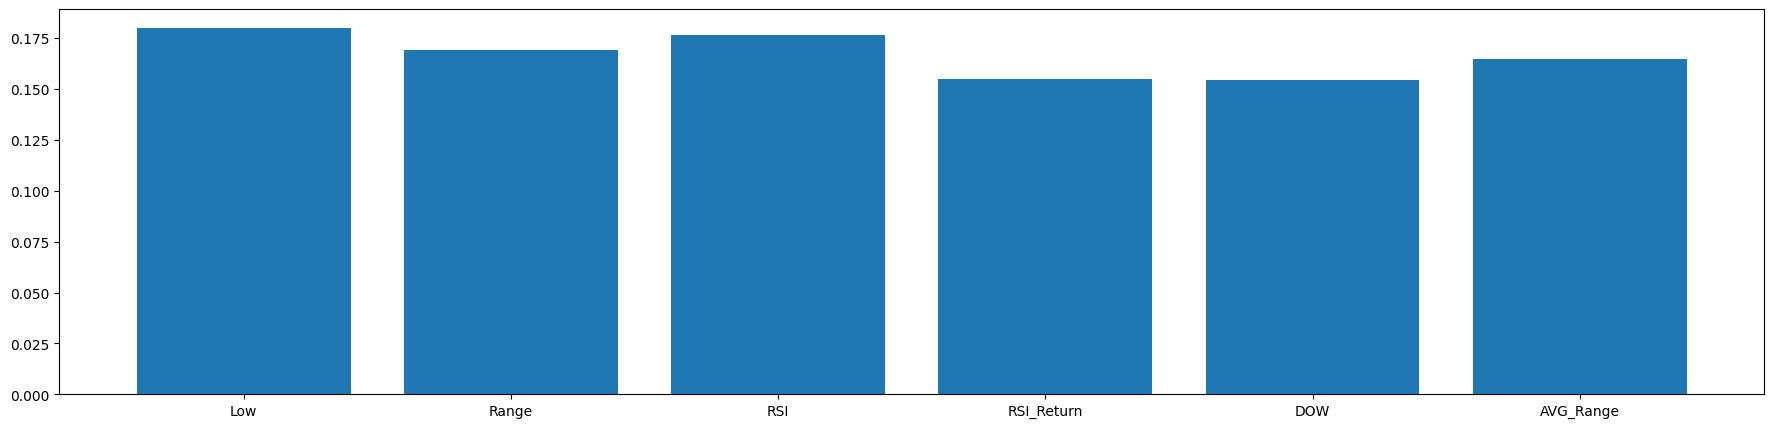

In [191]:
# Plot Feature Importance 
fig = plt.figure(figsize=(22,5))
importance_labels = X.columns
importance_features = classifier.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

### XG BOOST TREE

In [192]:
# # Plot Decision Tree
# import os
# os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'
# rcParams["figure.figsize"] = 80,50
# plot_tree(classifier)